Классификация электронной почты на спам и не-спам представляет собой задачу машинного обучения, где целью является автоматическое определение, является ли входящее сообщение спамом или нет. Это важная задача в области информационной безопасности и повседневной электронной коммуникации, так как помогает фильтровать нежелательные сообщения.

### Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

device = torch.device("cpu")

c:\Users\cgvgv\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Загрузка и предварительный анализ данных

In [2]:
df = pd.read_csv("spamdata_v2.csv")
df.head(10)

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [4]:
df['label'].value_counts(normalize = True)

label
0    0.865937
1    0.134063
Name: proportion, dtype: float64

###  Разделение набора данных на обучающее, валидационные и тестовые выборки

In [5]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2023, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2023, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

### Загрузка BERT

In [6]:
bert = AutoModel.from_pretrained('bert-base-uncased')

# Загрузка токенизатора BERT
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

### Подготовка двнных

<Axes: >

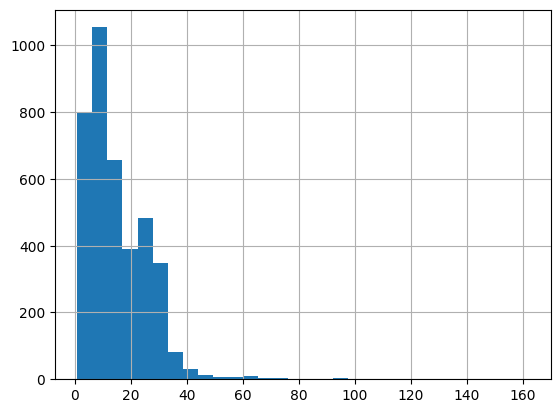

In [9]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [10]:
max_seq_len = 25
     

In [11]:
# токенизация в тренировочном наборе
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

 # токенизация в валидоционном наборе
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

#  # токенизация в тестовом наборе
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

c:\Users\cgvgv\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### Конвертация в тензоры

In [12]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

### Подготовка данных для обучения модели

In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

### Заморозка параметров

In [14]:
for param in bert.parameters():
    param.requires_grad = False

### Описание класса BERT_Arch, где BERT используется как энкодер для извлечения признаков, и далее эти признаки передаются через полносвязные слои для классификации

In [15]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,2)
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)

      return x

In [16]:
model = BERT_Arch(bert)
model = model.to(device)

### Определение оптимизатора для обучения модели с использованием библиотеки Hugging Face Transformers

In [17]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr = 1e-3)

c:\Users\cgvgv\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
from sklearn.utils.class_weight import compute_class_weight

class_wts = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)

class_wts

array([0.57743559, 3.72848948])

In [19]:
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

cross_entropy  = nn.NLLLoss(weight=weights) 

epochs = 10

#### 7. Fine-tune model

In [20]:
def to_np(x):
    "Convert a tensor to a numpy array."
    return (lambda o: o.data.cpu().numpy(), x)

### Обучение модели

In [21]:
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  total_preds=[]

  for step,batch in enumerate(train_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    model.zero_grad()        
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels)
    total_loss = total_loss + loss.item()
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    preds=preds.detach().cpu().numpy()
    total_preds.append(preds)

  avg_loss = total_loss / len(train_dataloader)
  
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

### Оценка модели

In [22]:
def evaluate():
  
  print("\nEvaluating...")
  
  model.eval()
  total_loss, total_accuracy = 0, 0
  total_preds = []

  for step,batch in enumerate(val_dataloader):
    if step % 50 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    with torch.no_grad():

      preds = model(sent_id, mask)
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  avg_loss = total_loss / len(val_dataloader) 
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [23]:
best_valid_loss = float('inf')

train_losses=[]
valid_losses=[]

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_loss, _ = train()
    valid_loss, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10


  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.520
Validation Loss: 0.373

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.321
Validation Loss: 0.362

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.318
Validation Loss: 0.145

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.256
Validation Loss: 0.239

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.239
Validation Loss: 0.129

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.227
Validation Loss: 0.162

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.274
Validation Loss: 0.138

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.214
Validation Loss: 0.131

In [24]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

### Создание отчета о классификации

In [55]:
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [56]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

preds = np.argmax(preds, axis=1)

# Рассчёт  и вывод метрик
accuracy = accuracy_score(test_y, preds)
precision, recall, f1_score, _ = precision_recall_fscore_support(test_y, preds, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')

Accuracy: 0.9653
Precision: 0.9661
Recall: 0.9653
F1 Score: 0.9656


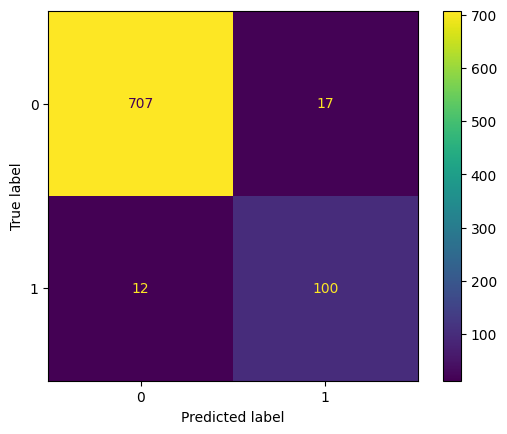

In [42]:
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = sklearn.metrics.confusion_matrix(test_y, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Итоги:
Обученная модель показала высокую точность (96,5%).
Высокая точность объясняется простотой задачи и мощью нейронной сети BERT.